In [12]:
import pandas as pd
import torch
import re
import nltk
import emoji
import matplotlib.pyplot as plt
import seaborn as sns


from tqdm import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModel
from TweetNormalizer import normalizeTweet

In [13]:
# Check if GPU is available
'cuda' if torch.cuda.is_available() else 'cpu'

'cuda'

In [3]:
# Load your data
file_path = 'C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/suomi24/Data/suomi24.csv'
df = pd.read_csv(file_path)
df

,msg_type,datetime,title,thread_id,comment_id,topic_name_top,topic_name_leaf,thread_text,title_processed,topic_name_top_processed,topic_name_leaf_processed,thread_text_processed,unique_word_ratio,word_count,combined_processed,thread_text_hypothesis,combined_hypothesis
0,thread_start,10/21/2008 15:10,2008,6382354,0,Groups,40 plus,"but despised and questioned yes. 2008 Well, we...",NaN,groups,plus,but despised and questioned yes well we though...,0.768293,82,groups plus but despised and questioned yes w...,H4,H4
1,comment,10/21/2008 16:34,2008,6382354,33460404,Groups,40 plus,Orwell was a seer. In '84 the world didn't exa...,NaN,groups,plus,orwell was a seer in the world did not exactly...,0.928571,14,groups plus orwell was a seer in the world di...,H4,H4
2,comment,3/19/2016 9:40,- I don't know. - What's the payoff?,14185813,83782764,Hobbies,Electronics,which did not protect the car owner from the r...,i do not know whats the payoff,hobbies,electronics,which did not protect the car owner from the r...,0.537879,132,i do not know whats the payoff hobbies electro...,H3,H3
3,comment,3/25/2016 23:48,- I don't know. - What's the payoff?,14185813,83896363,Hobbies,Electronics,"the cashier will have a ""card reported as miss...",i do not know whats the payoff,hobbies,electronics,the cashier will have a card reported as missi...,0.554054,148,i do not know whats the payoff hobbies electro...,H2,H2
4,comment,4/11/2016 23:06,- I don't know. - What's the payoff?,14185813,84156873,Hobbies,Electronics,but do those only Mastercard Kredit cards with...,i do not know whats the payoff,hobbies,electronics,but do those only mastercard kredit cards with...,0.562500,96,i do not know whats the payoff hobbies electro...,H2,H2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217996,comment,3/16/2013 11:54,Localities,11340784,60550054,Localities,Nickel,thank you. Who could make it happen? Camera St...,localities,localities,nickel,thank you who could make it happen camera stel...,1.000000,14,localities localities nickel thank you who cou...,H2,H1
217997,comment,1/16/2015 15:03,Vehicles and transport,13305552,77069109,Vehicles and transport,Public transport,This rave junta now put the lives of possibly ...,vehicles and transport,vehicles and transport,public transport,this rave junta now put the lives of possibly ...,1.000000,15,vehicles and transport vehicles and transport ...,H0,H4
217998,comment,3/18/2013 13:55,Localities,11340784,60588127,Localities,Nickel,It would be nice to see what's going on there ...,localities,localities,nickel,it would be nice to see what is going on there...,1.000000,16,localities localities nickel it would be nice ...,H2,H1
217999,comment,3/30/2006 8:55,Localities,2778360,14276358,Localities,Rovaniemi,did not prevent our table from stealing. Its a...,localities,localities,rovaniemi,did not prevent our table from stealing its a ...,1.000000,17,localities localities rovaniemi did not preven...,H1,H4


In [4]:
# Load your data
file_path = 'suomi24_with_sentiment.csv'
dff = pd.read_csv(file_path)
dff

,msg_type,datetime,title,thread_id,comment_id,topic_name_top,topic_name_leaf,thread_text,title_processed,topic_name_top_processed,topic_name_leaf_processed,thread_text_processed,unique_word_ratio,word_count,combined_processed,normalized_text,thread_text_normalized,combined_normalized,thread_text_sentiment,combined_sentiment
0,thread_start,10/21/2008 15:10,2008,6382354,0,Groups,40 plus,"but despised and questioned yes. 2008 Well, we...",NaN,groups,plus,but despised and questioned yes well we though...,0.768293,82,groups plus but despised and questioned yes w...,but despised and questioned yes well we though...,but despised and questioned yes well we though...,groups plus but despised and questioned yes we...,1,1
1,comment,10/21/2008 16:34,2008,6382354,33460404,Groups,40 plus,Orwell was a seer. In '84 the world didn't exa...,NaN,groups,plus,orwell was a seer in the world did not exactly...,0.928571,14,groups plus orwell was a seer in the world di...,orwell was a seer in the world did not exactly...,orwell was a seer in the world did not exactly...,groups plus orwell was a seer in the world did...,1,1
2,comment,3/19/2016 9:40,- I don't know. - What's the payoff?,14185813,83782764,Hobbies,Electronics,which did not protect the car owner from the r...,i do not know whats the payoff,hobbies,electronics,which did not protect the car owner from the r...,0.537879,132,i do not know whats the payoff hobbies electro...,which did not protect the car owner from the r...,which did not protect the car owner from the r...,i do not know whats the payoff hobbies electro...,1,1
3,comment,3/25/2016 23:48,- I don't know. - What's the payoff?,14185813,83896363,Hobbies,Electronics,"the cashier will have a ""card reported as miss...",i do not know whats the payoff,hobbies,electronics,the cashier will have a card reported as missi...,0.554054,148,i do not know whats the payoff hobbies electro...,the cashier will have a card reported as missi...,the cashier will have a card reported as missi...,i do not know whats the payoff hobbies electro...,1,1
4,comment,4/11/2016 23:06,- I don't know. - What's the payoff?,14185813,84156873,Hobbies,Electronics,but do those only Mastercard Kredit cards with...,i do not know whats the payoff,hobbies,electronics,but do those only mastercard kredit cards with...,0.562500,96,i do not know whats the payoff hobbies electro...,but do those only mastercard kredit cards with...,but do those only mastercard kredit cards with...,i do not know whats the payoff hobbies electro...,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217996,comment,3/16/2013 11:54,Localities,11340784,60550054,Localities,Nickel,thank you. Who could make it happen? Camera St...,localities,localities,nickel,thank you who could make it happen camera stel...,1.000000,14,localities localities nickel thank you who cou...,thank you who could make it happen camera stel...,thank you who could make it happen camera stel...,localities localities nickel thank you who cou...,1,1
217997,comment,1/16/2015 15:03,Vehicles and transport,13305552,77069109,Vehicles and transport,Public transport,This rave junta now put the lives of possibly ...,vehicles and transport,vehicles and transport,public transport,this rave junta now put the lives of possibly ...,1.000000,15,vehicles and transport vehicles and transport ...,this rave junta now put the lives of possibly ...,this rave junta now put the lives of possibly ...,vehicles and transport vehicles and transport ...,1,1
217998,comment,3/18/2013 13:55,Localities,11340784,60588127,Localities,Nickel,It would be nice to see what's going on there ...,localities,localities,nickel,it would be nice to see what is going on there...,1.000000,16,localities localities nickel it would be nice ...,it would be nice to see what is going on there...,it would be nice to see what is going on there...,localities localities nickel it would be nice ...,1,1
217999,comment,3/30/2006 8:55,Localities,2778360,142763

In [5]:
df['thread_text_sentiment'] = dff['thread_text_sentiment']
df['combined_sentiment'] = dff['combined_sentiment']

In [ ]:
# df = df.drop(['word_count', 'unique_word_ratio', 'bertweet_processed', 'processed_text'], axis=1)

In [6]:
df

,msg_type,datetime,title,thread_id,comment_id,topic_name_top,topic_name_leaf,thread_text,title_processed,topic_name_top_processed,topic_name_leaf_processed,thread_text_processed,unique_word_ratio,word_count,combined_processed,thread_text_hypothesis,combined_hypothesis,thread_text_sentiment,combined_sentiment
0,thread_start,10/21/2008 15:10,2008,6382354,0,Groups,40 plus,"but despised and questioned yes. 2008 Well, we...",NaN,groups,plus,but despised and questioned yes well we though...,0.768293,82,groups plus but despised and questioned yes w...,H4,H4,1,1
1,comment,10/21/2008 16:34,2008,6382354,33460404,Groups,40 plus,Orwell was a seer. In '84 the world didn't exa...,NaN,groups,plus,orwell was a seer in the world did not exactly...,0.928571,14,groups plus orwell was a seer in the world di...,H4,H4,1,1
2,comment,3/19/2016 9:40,- I don't know. - What's the payoff?,14185813,83782764,Hobbies,Electronics,which did not protect the car owner from the r...,i do not know whats the payoff,hobbies,electronics,which did not protect the car owner from the r...,0.537879,132,i do not know whats the payoff hobbies electro...,H3,H3,1,1
3,comment,3/25/2016 23:48,- I don't know. - What's the payoff?,14185813,83896363,Hobbies,Electronics,"the cashier will have a ""card reported as miss...",i do not know whats the payoff,hobbies,electronics,the cashier will have a card reported as missi...,0.554054,148,i do not know whats the payoff hobbies electro...,H2,H2,1,1
4,comment,4/11/2016 23:06,- I don't know. - What's the payoff?,14185813,84156873,Hobbies,Electronics,but do those only Mastercard Kredit cards with...,i do not know whats the payoff,hobbies,electronics,but do those only mastercard kredit cards with...,0.562500,96,i do not know whats the payoff hobbies electro...,H2,H2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217996,comment,3/16/2013 11:54,Localities,11340784,60550054,Localities,Nickel,thank you. Who could make it happen? Camera St...,localities,localities,nickel,thank you who could make it happen camera stel...,1.000000,14,localities localities nickel thank you who cou...,H2,H1,1,1
217997,comment,1/16/2015 15:03,Vehicles and transport,13305552,77069109,Vehicles and transport,Public transport,This rave junta now put the lives of possibly ...,vehicles and transport,vehicles and transport,public transport,this rave junta now put the lives of possibly ...,1.000000,15,vehicles and transport vehicles and transport ...,H0,H4,1,1
217998,comment,3/18/2013 13:55,Localities,11340784,60588127,Localities,Nickel,It would be nice to see what's going on there ...,localities,localities,nickel,it would be nice to see what is going on there...,1.000000,16,localities localities nickel it would be nice ...,H2,H1,1,1
217999,comment,3/30/2006 8:55,Localities,2778360,14276358,Localities,Rovaniemi,did not prevent our table from stealing. Its a...,localities,localities,rovaniemi,did not prevent our table from stealing its a ...,1.000000,17,localities localities rovaniemi did not preven...,H1,H4,1,1


In [91]:
# Dictionary for contractions
contraction_dict = {
    "it's": "it is", "aren't": "are not", "can't": "cannot", "couldn't": "could not",
    "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not",
    "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'll": "he will",
    "he's": "he is", "I'd": "I would", "I'll": "I will", "I'm": "I am", "I've": "I have",
    "isn't": "is not", "it's": "it is", "let's": "let us", "might've": "might have",
    "must've": "must have", "mustn't": "must not", "shan't": "shall not", "she'd": "she would",
    "she'll": "she will", "she's": "she is", "should've": "should have", "shouldn't": "should not",
    "that's": "that is", "there's": "there is", "they'd": "they would", "they'll": "they will",
    "they're": "they are", "they've": "they have", "we'd": "we would", "we're": "we are",
    "we've": "we have", "weren't": "were not", "what'll": "what will", "what're": "what are",
    "what's": "what is", "what've": "what have", "where's": "where is", "who'd": "who would",
    "who'll": "who will", "who's": "who is", "who've": "who have", "won't": "will not",
    "wouldn't": "would not", "you'd": "you would", "you'll": "you will", "you're": "you are",
    "you've": "you have"
}

def preprocess_text(text):
    # Regex to match:
    # 1. Any possible email address format
    # 2. URLs starting with http/https and ending with .com or .fi (with optional spaces)
    # 3. Any string that includes a slash (assumed to be a path or URL)
    # 4. Domain-like strings that end with .com or .fi, including spaces before the extensions
    patterns = [
        r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\b',  # Email addresses, more inclusive to capture 'username@hostname'
        r'https?://[^ ]*\.(com|fi)\b',             # Full URLs
        r'\b[^ ]+/[^ ]+\b',                        # Paths with slashes
        r'\b[^ ]*\.\s*(com|fi)\b'                  # Domains with optional spaces
    ]
    combined_pattern = r'|'.join(patterns)
    text = re.sub(combined_pattern, '', text)
    words = text.split()
    text = " ".join([contraction_dict.get(word, word) for word in words]) # replace contractions
    text = re.sub(r'\b\w*(-\w*)+\b', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text) # remove non-letter characters
    text = re.sub(r'&[^;\s]*', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.lower()  # Convert to lower case
    return text

tqdm.pandas(desc="Processing")

df['title_processed'] = df['title'].progress_apply(preprocess_text)
df['topic_name_top_processed'] = df['topic_name_top'].progress_apply(preprocess_text)
df['topic_name_leaf_processed'] = df['topic_name_leaf'].progress_apply(preprocess_text)
df['thread_text_processed'] = df['thread_text'].progress_apply(preprocess_text)

df['combined_processed'] = df[['title_processed', 'topic_name_top_processed', 'topic_name_leaf_processed', 'thread_text_processed']].progress_apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)

# df.to_csv('suomi24_bertweet_processed.csv', index=False)

In [92]:
# Function to calculate the ratio of unique words to total words
def unique_word_ratio(text):
    words = text.split()
    unique_words = set(words)
    if len(words) == 0:  # Avoid division by zero
        return 0
    return len(unique_words) / len(words)

# Apply the function to the 'processed_text' column
df['unique_word_ratio'] = df['thread_text_processed'].apply(unique_word_ratio)

# Add a column for word count
df['word_count'] = df['thread_text_processed'].apply(lambda text: len(text.split()))

# Filter rows where 'unique_word_ratio' is less than or equal to 0.4 and word count is less than 7
df = df[(df['unique_word_ratio'] > 0.4) & (df['word_count'] >= 7)]
# Filter rows where 'unique_word_ratio' is less than or equal to 0.4
# df = df[df['unique_word_ratio'] >= 0.4]

# Define a new order of columns where 'bertweet_processed' is at the end
# column_order = [col for col in df.columns if col not in ['bertweet_processed', 'unique_word_ratio', 'word_count']]
# column_order += ['unique_word_ratio', 'word_count', 'bertweet_processed']
# df = df[column_order]

# Save the DataFrame with the new information
df.to_csv('suomi24_bertweet_processed.csv', index=False)


In [113]:
df['normalized_text'][0]

'but despised and questioned yes well we thought about the world with a larger group the customer had noticed the video camera health centers procedure in a room where we should have taken off dw when the internet came this can no longer even be surprised orwel wrote his book in time sitting in in a bar while studying and thinking about how the world was going now it was in the paper that in a small village here in southern finland'

In [88]:
df.to_csv('suomi24_bertweet_processed.csv', index=False)


In [ ]:
# Basic text preprocessing function
stop_words = set(stopwords.words('english'))
stop_words.add('s')
stop_words.add('ve')
stop_words.add('re')
stop_words.add('m')
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()  # Convert to lower case
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with single space
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\b\w{1,2}\b', '', text) # Remove single and double character words
    text = text.lower()  # Convert to lower case
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing to the 'thread_text' column
df['processed_text'] = df['thread_text'].astype(str).apply(preprocess_text)


In [98]:
# Load the tokenizer for BERTweet
tokenizer = AutoTokenizer.from_pretrained('vinai/bertweet-large')

# Tokenize the 'processed_text' column and check their lengths
token_lengths = df['combined_processed'].apply(lambda text: len(tokenizer.encode(text, add_special_tokens=True)))

# Display some basic statistics about token lengths
print("Token Lengths Statistics:")
print(token_lengths.describe())

# Find if any text exceeds BERTweet's max length (typically 128 for BERTweet Base)
max_length = 512
exceeds = (token_lengths > max_length).sum()
print(f"\nNumber of texts exceeding {max_length} tokens: {exceeds}")

# Display specific rows that exceed the maximum length
if exceeds > 0:
    print("\nTexts exceeding the maximum token length:")
    print(df.loc[token_lengths > max_length, 'combined_processed'])


Token Lengths Statistics:
count    218001.000000
mean         74.516947
std          39.961957
min          14.000000
25%          42.000000
50%          63.000000
75%         100.000000
max         371.000000
Name: combined_processed, dtype: float64

Number of texts exceeding 512 tokens: 0


In [97]:
# Load the tokenizer for BERTweet
tokenizer = AutoTokenizer.from_pretrained('vinai/bertweet-large')

# Tokenize the 'processed_text' column and check their lengths
token_lengths = df['thread_text_processed'].apply(lambda text: len(tokenizer.encode(text, add_special_tokens=True)))

# Display some basic statistics about token lengths
print("Token Lengths Statistics:")
print(token_lengths.describe())

# Find if any text exceeds BERTweet's max length (typically 128 for BERTweet Base)
max_length = 512
exceeds = (token_lengths > max_length).sum()
print(f"\nNumber of texts exceeding {max_length} tokens: {exceeds}")

# Display specific rows that exceed the maximum length
if exceeds > 0:
    print("\nTexts exceeding the maximum token length:")
    print(df.loc[token_lengths > max_length, 'thread_text_processed'])


Token Lengths Statistics:
count    218001.000000
mean         63.979615
std          40.061274
min           9.000000
25%          31.000000
50%          53.000000
75%          90.000000
max         359.000000
Name: thread_text_processed, dtype: float64

Number of texts exceeding 512 tokens: 0


In [117]:
torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device(type='cuda')

In [149]:
# Apply normalization to the relevant column
tqdm.pandas(desc="Processing")
df['thread_text_normalized'] = df['thread_text_processed'].progress_apply(normalizeTweet)
df['combined_normalized'] = df['combined_processed'].progress_apply(normalizeTweet)

Processing: 100%|██████████| 218001/218001 [01:34<00:00, 2302.34it/s]


In [146]:
# Load BERTweet model and tokenizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-large")
# model = AutoModel.from_pretrained("vinai/bertweet-large")
model = AutoModelForSequenceClassification.from_pretrained("vinai/bertweet-large")
model.to(device)
model.eval()

# Function to predict sentiment
def predict_sentiment(text, tokenizer, model, device):
    inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True, padding=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
        sentiment = torch.argmax(probabilities, dim=-1).item()
    return sentiment

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [150]:
# Apply sentiment analysis to the normalized text
tqdm.pandas(desc="Processing")
df['thread_text_sentiment'] = df['thread_text_normalized'].progress_apply(lambda x: predict_sentiment(x, tokenizer, model, device))
df['combined_sentiment'] = df['combined_normalized'].progress_apply(lambda x: predict_sentiment(x, tokenizer, model, device))

# Save the DataFrame with sentiment scores
df.to_csv('suomi24_with_hypothesis_sentiment.csv', index=False)

Processing: 100%|██████████| 218001/218001 [1:35:18<00:00, 38.12it/s]


In [7]:
# Save the DataFrame with sentiment scores
df.to_csv('suomi24_with_hypothesis_sentiment.csv', index=False)

In [151]:
df

,msg_type,datetime,title,thread_id,comment_id,topic_name_top,topic_name_leaf,thread_text,title_processed,topic_name_top_processed,topic_name_leaf_processed,thread_text_processed,unique_word_ratio,word_count,combined_processed,normalized_text,thread_text_normalized,combined_normalized,thread_text_sentiment,combined_sentiment
0,thread_start,10/21/2008 15:10,2008,6382354,0,Groups,40 plus,"but despised and questioned yes. 2008 Well, we...",,groups,plus,but despised and questioned yes well we though...,0.768293,82,groups plus but despised and questioned yes w...,but despised and questioned yes well we though...,but despised and questioned yes well we though...,groups plus but despised and questioned yes we...,1,1
1,comment,10/21/2008 16:34,2008,6382354,33460404,Groups,40 plus,Orwell was a seer. In '84 the world didn't exa...,,groups,plus,orwell was a seer in the world did not exactly...,0.928571,14,groups plus orwell was a seer in the world di...,orwell was a seer in the world did not exactly...,orwell was a seer in the world did not exactly...,groups plus orwell was a seer in the world did...,1,1
2,comment,3/19/2016 9:40,- I don't know. - What's the payoff?,14185813,83782764,Hobbies,Electronics,which did not protect the car owner from the r...,i do not know whats the payoff,hobbies,electronics,which did not protect the car owner from the r...,0.537879,132,i do not know whats the payoff hobbies electro...,which did not protect the car owner from the r...,which did not protect the car owner from the r...,i do not know whats the payoff hobbies electro...,1,1
3,comment,3/25/2016 23:48,- I don't know. - What's the payoff?,14185813,83896363,Hobbies,Electronics,"the cashier will have a ""card reported as miss...",i do not know whats the payoff,hobbies,electronics,the cashier will have a card reported as missi...,0.554054,148,i do not know whats the payoff hobbies electro...,the cashier will have a card reported as missi...,the cashier will have a card reported as missi...,i do not know whats the payoff hobbies electro...,1,1
4,comment,4/11/2016 23:06,- I don't know. - What's the payoff?,14185813,84156873,Hobbies,Electronics,but do those only Mastercard Kredit cards with...,i do not know whats the payoff,hobbies,electronics,but do those only mastercard kredit cards with...,0.562500,96,i do not know whats the payoff hobbies electro...,but do those only mastercard kredit cards with...,but do those only mastercard kredit cards with...,i do not know whats the payoff hobbies electro...,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217996,comment,3/16/2013 11:54,Localities,11340784,60550054,Localities,Nickel,thank you. Who could make it happen? Camera St...,localities,localities,nickel,thank you who could make it happen camera stel...,1.000000,14,localities localities nickel thank you who cou...,thank you who could make it happen camera stel...,thank you who could make it happen camera stel...,localities localities nickel thank you who cou...,1,1
217997,comment,1/16/2015 15:03,Vehicles and transport,13305552,77069109,Vehicles and transport,Public transport,This rave junta now put the lives of possibly ...,vehicles and transport,vehicles and transport,public transport,this rave junta now put the lives of possibly ...,1.000000,15,vehicles and transport vehicles and transport ...,this rave junta now put the lives of possibly ...,this rave junta now put the lives of possibly ...,vehicles and transport vehicles and transport ...,1,1
217998,comment,3/18/2013 13:55,Localities,11340784,60588127,Localities,Nickel,It would be nice to see what's going on there ...,localities,localities,nickel,it would be nice to see what is going on there...,1.000000,16,localities localities nickel it would be nice ...,it would be nice to see what is going on there...,it would be nice to see what is going on there...,localities localities nickel it would be nice ...,1,1
217999,comment,3/30/2006 8:55,Localities,2778360,14276358,Loc

C:\Users\fahad\AppData\Local\Temp\ipykernel_24924\1305783119.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='thread_text_sentiment', data=df, palette='viridis')


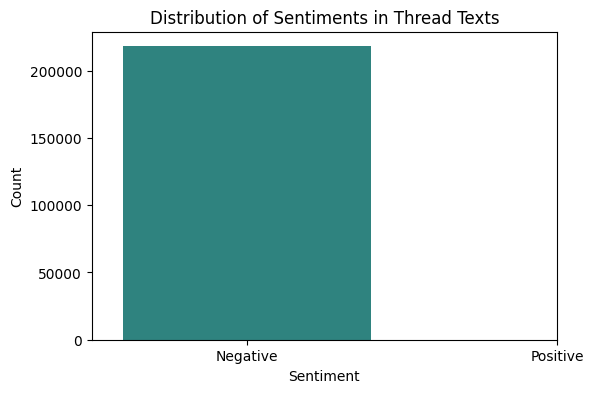

C:\Users\fahad\AppData\Local\Temp\ipykernel_24924\1305783119.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='combined_sentiment', data=df, palette='viridis')


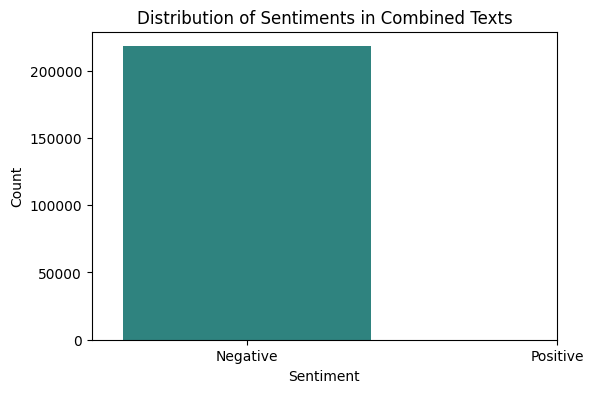

In [154]:
# Plot the distribution of sentiments in thread texts
plt.figure(figsize=(6, 4))
sns.countplot(x='thread_text_sentiment', data=df, palette='viridis')
plt.title('Distribution of Sentiments in Thread Texts')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()

# Plot the distribution of sentiments in combined texts
plt.figure(figsize=(6, 4))
sns.countplot(x='combined_sentiment', data=df, palette='viridis')
plt.title('Distribution of Sentiments in Combined Texts')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()


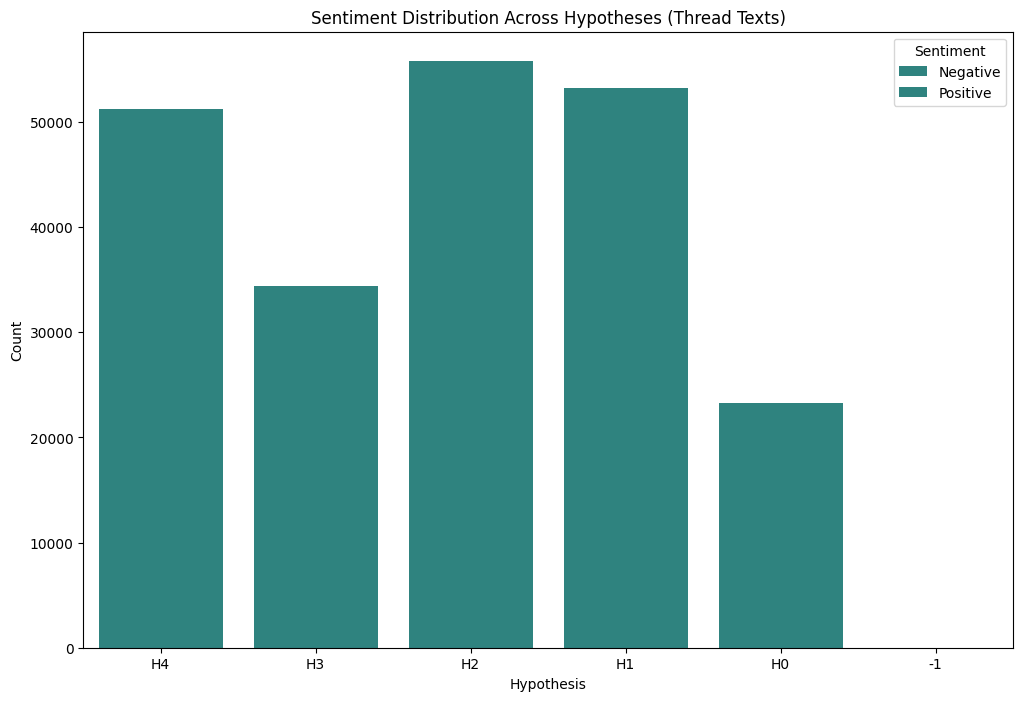

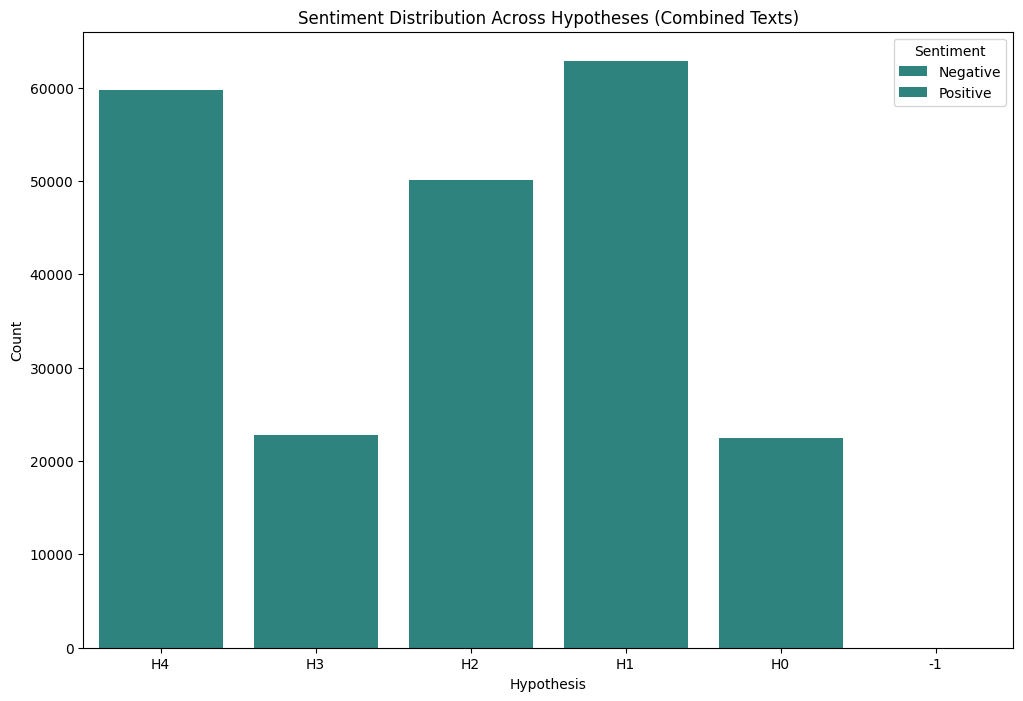

In [13]:
# Plot the distribution of sentiments across hypotheses for thread texts
plt.figure(figsize=(12, 8))
sns.countplot(x='thread_text_hypothesis', hue='thread_text_sentiment', data=df, palette='viridis')
plt.title('Sentiment Distribution Across Hypotheses (Thread Texts)')
plt.xlabel('Hypothesis')
plt.ylabel('Count')
plt.legend(title='Sentiment', labels=['Negative', 'Positive'])
plt.show()

# Plot the distribution of sentiments across hypotheses for combined texts
plt.figure(figsize=(12, 8))
sns.countplot(x='combined_hypothesis', hue='combined_sentiment', data=df, palette='viridis')
plt.title('Sentiment Distribution Across Hypotheses (Combined Texts)')
plt.xlabel('Hypothesis')
plt.ylabel('Count')
plt.legend(title='Sentiment', labels=['Negative', 'Positive'])
plt.show()


C:\Users\fahad\AppData\Local\Temp\ipykernel_24924\133667699.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='thread_text_sentiment', y='word_count', data=df, palette='viridis')


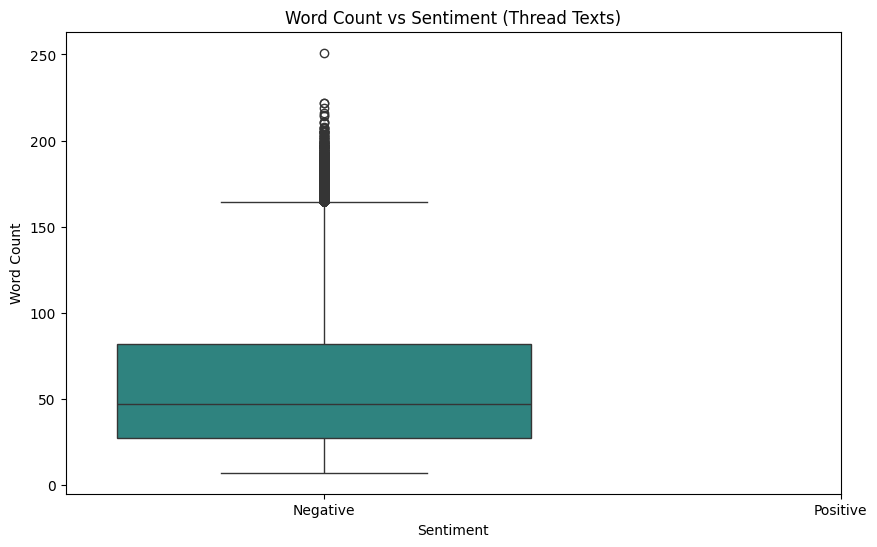

C:\Users\fahad\AppData\Local\Temp\ipykernel_24924\133667699.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='combined_sentiment', y='word_count', data=df, palette='viridis')


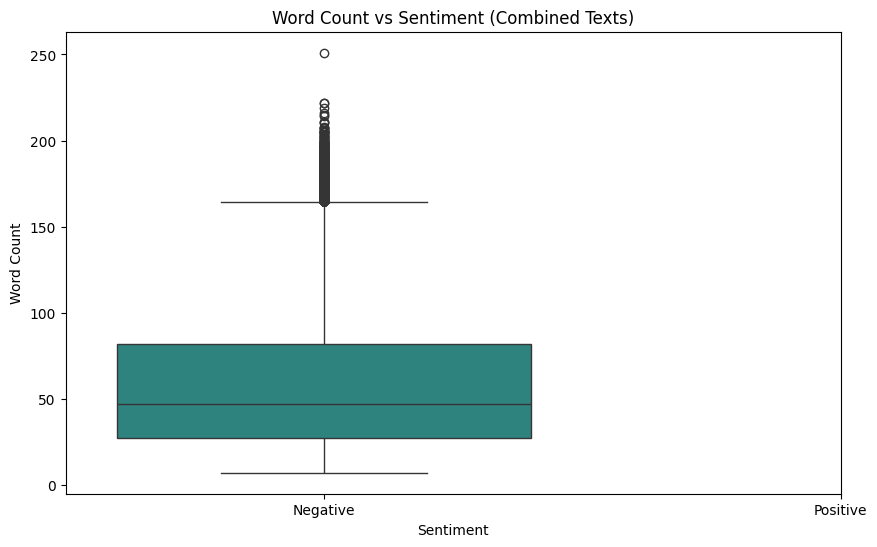

In [156]:
# Plot word count vs sentiment
plt.figure(figsize=(10, 6))
sns.boxplot(x='thread_text_sentiment', y='word_count', data=df, palette='viridis')
plt.title('Word Count vs Sentiment (Thread Texts)')
plt.xlabel('Sentiment')
plt.ylabel('Word Count')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()

# Plot word count vs sentiment for combined texts
plt.figure(figsize=(10, 6))
sns.boxplot(x='combined_sentiment', y='word_count', data=df, palette='viridis')
plt.title('Word Count vs Sentiment (Combined Texts)')
plt.xlabel('Sentiment')
plt.ylabel('Word Count')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()


C:\Users\fahad\AppData\Local\Temp\ipykernel_24924\2241434989.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='thread_text_sentiment', y='unique_word_ratio', data=df, palette='viridis')


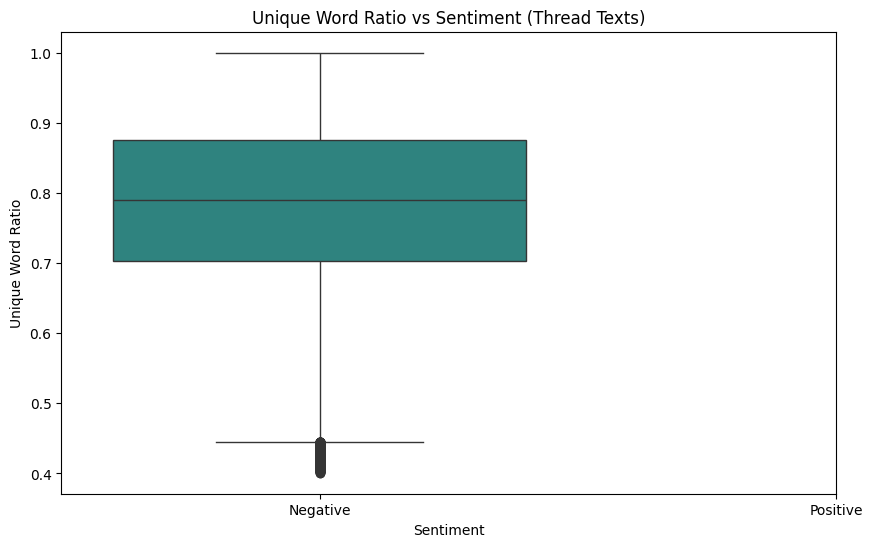

C:\Users\fahad\AppData\Local\Temp\ipykernel_24924\2241434989.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='combined_sentiment', y='unique_word_ratio', data=df, palette='viridis')


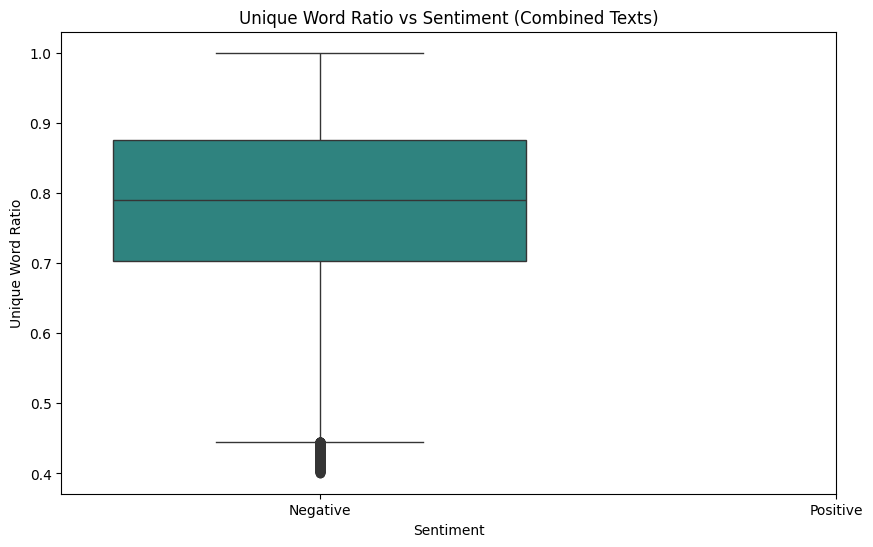

In [157]:
# Plot unique word ratio vs sentiment
plt.figure(figsize=(10, 6))
sns.boxplot(x='thread_text_sentiment', y='unique_word_ratio', data=df, palette='viridis')
plt.title('Unique Word Ratio vs Sentiment (Thread Texts)')
plt.xlabel('Sentiment')
plt.ylabel('Unique Word Ratio')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()

# Plot unique word ratio vs sentiment for combined texts
plt.figure(figsize=(10, 6))
sns.boxplot(x='combined_sentiment', y='unique_word_ratio', data=df, palette='viridis')
plt.title('Unique Word Ratio vs Sentiment (Combined Texts)')
plt.xlabel('Sentiment')
plt.ylabel('Unique Word Ratio')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()


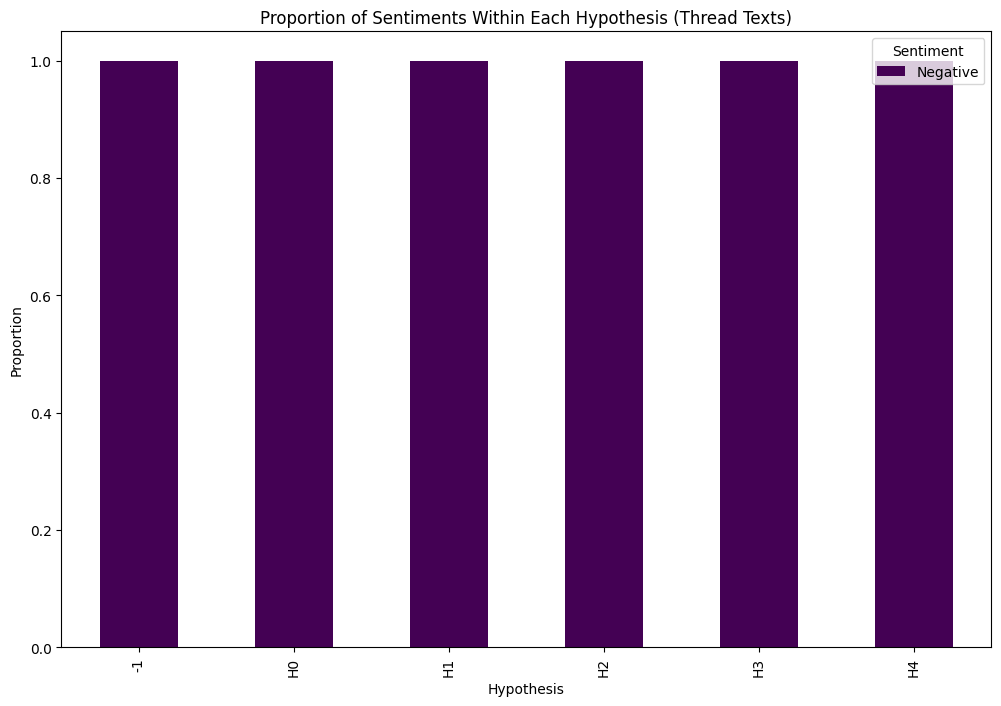

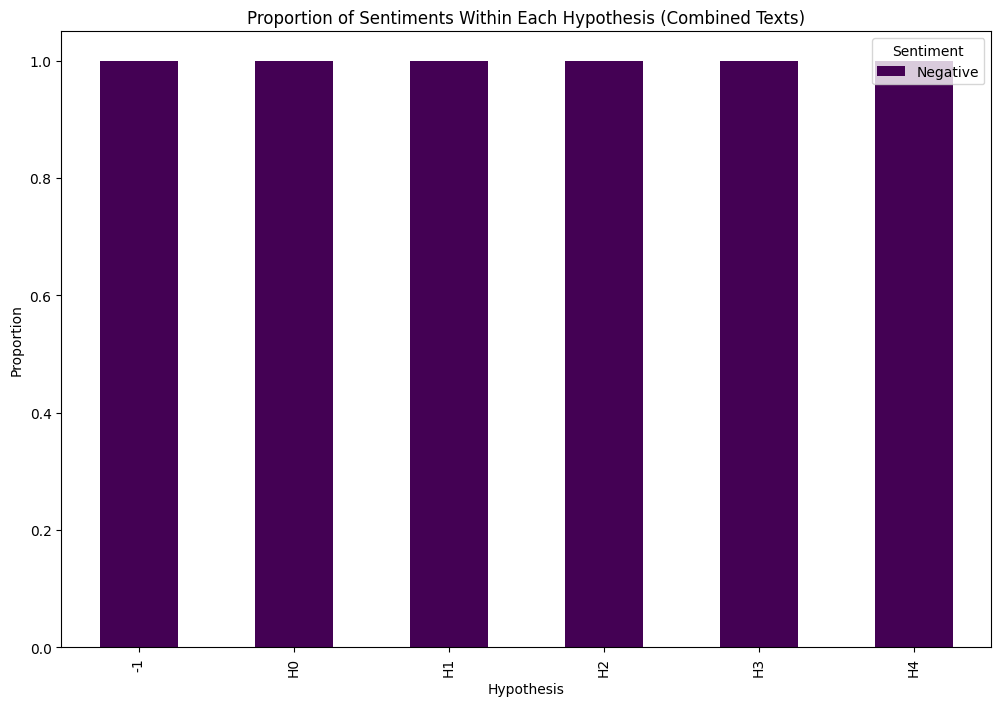

In [14]:
# Calculate proportions of sentiments within each hypothesis
hypothesis_sentiment_proportions = df.groupby('thread_text_hypothesis')['thread_text_sentiment'].value_counts(normalize=True).unstack()

# Plot the proportions
hypothesis_sentiment_proportions.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='viridis')
plt.title('Proportion of Sentiments Within Each Hypothesis (Thread Texts)')
plt.xlabel('Hypothesis')
plt.ylabel('Proportion')
plt.legend(title='Sentiment', labels=['Negative', 'Positive'])
plt.show()

# Calculate proportions of sentiments within each hypothesis for combined texts
hypothesis_sentiment_proportions_combined = df.groupby('combined_hypothesis')['combined_sentiment'].value_counts(normalize=True).unstack()

# Plot the proportions
hypothesis_sentiment_proportions_combined.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='viridis')
plt.title('Proportion of Sentiments Within Each Hypothesis (Combined Texts)')
plt.xlabel('Hypothesis')
plt.ylabel('Proportion')
plt.legend(title='Sentiment', labels=['Negative', 'Positive'])
plt.show()


In [161]:
df

,msg_type,datetime,title,thread_id,comment_id,topic_name_top,topic_name_leaf,thread_text,title_processed,topic_name_top_processed,topic_name_leaf_processed,thread_text_processed,unique_word_ratio,word_count,combined_processed,thread_text_hypothesis,combined_hypothesis
0,thread_start,10/21/2008 15:10,2008,6382354,0,Groups,40 plus,"but despised and questioned yes. 2008 Well, we...",NaN,groups,plus,but despised and questioned yes well we though...,0.768293,82,groups plus but despised and questioned yes w...,H4,H4
1,comment,10/21/2008 16:34,2008,6382354,33460404,Groups,40 plus,Orwell was a seer. In '84 the world didn't exa...,NaN,groups,plus,orwell was a seer in the world did not exactly...,0.928571,14,groups plus orwell was a seer in the world di...,H4,H4
2,comment,3/19/2016 9:40,- I don't know. - What's the payoff?,14185813,83782764,Hobbies,Electronics,which did not protect the car owner from the r...,i do not know whats the payoff,hobbies,electronics,which did not protect the car owner from the r...,0.537879,132,i do not know whats the payoff hobbies electro...,H3,H3
3,comment,3/25/2016 23:48,- I don't know. - What's the payoff?,14185813,83896363,Hobbies,Electronics,"the cashier will have a ""card reported as miss...",i do not know whats the payoff,hobbies,electronics,the cashier will have a card reported as missi...,0.554054,148,i do not know whats the payoff hobbies electro...,H2,H2
4,comment,4/11/2016 23:06,- I don't know. - What's the payoff?,14185813,84156873,Hobbies,Electronics,but do those only Mastercard Kredit cards with...,i do not know whats the payoff,hobbies,electronics,but do those only mastercard kredit cards with...,0.562500,96,i do not know whats the payoff hobbies electro...,H2,H2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217996,comment,3/16/2013 11:54,Localities,11340784,60550054,Localities,Nickel,thank you. Who could make it happen? Camera St...,localities,localities,nickel,thank you who could make it happen camera stel...,1.000000,14,localities localities nickel thank you who cou...,H2,H1
217997,comment,1/16/2015 15:03,Vehicles and transport,13305552,77069109,Vehicles and transport,Public transport,This rave junta now put the lives of possibly ...,vehicles and transport,vehicles and transport,public transport,this rave junta now put the lives of possibly ...,1.000000,15,vehicles and transport vehicles and transport ...,H0,H4
217998,comment,3/18/2013 13:55,Localities,11340784,60588127,Localities,Nickel,It would be nice to see what's going on there ...,localities,localities,nickel,it would be nice to see what is going on there...,1.000000,16,localities localities nickel it would be nice ...,H2,H1
217999,comment,3/30/2006 8:55,Localities,2778360,14276358,Localities,Rovaniemi,did not prevent our table from stealing. Its a...,localities,localities,rovaniemi,did not prevent our table from stealing its a ...,1.000000,17,localities localities rovaniemi did not preven...,H1,H4
